Esta fase de la metdologia consiste en extraer el valor de los datos desarrollando un modelo que aprenda de los patrones en estos.

* El diagrama en cuestion de esta fase esta a continuacion:

![Imagen_mapa](imagen_modelado_general.png)

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generator de imagenes
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.random.set_seed(42)#semilla 42, para la reproducibilidad de resultados

### Canalizacion de datos

* Preparamos la canalizacion de datos, a partir de las imagenes del disco.

In [4]:
train_datagen=ImageDataGenerator(
            rescale=1.0/255, #escalamos los datos en rangos de [-1,1] El modelo MobileNetv2 espera esta configuracion
            rotation_range = 45,
            zoom_range = 0.2,
            shear_range = 0.2,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode = 'nearest'
        )
#sobre los datos de validacion y test no se hace ningun aumento de datos.
validation_datagen=ImageDataGenerator(rescale=1.0/255) #escalamiento de validacion a un rango de [0,1]
test_datagen=ImageDataGenerator(rescale=1.0/255)       #escalamiento de test a un rango de [0,1]

In [5]:
#definimos las rutas para el acceso a los datos
train_path="../input/datasetscovidsplit/Datasets/train"
validation_path="../input/datasetscovidsplit/Datasets/val"
test_path="../input/datasetscovidsplit/Datasets/test"

#creamos los generadores de datos a partir de los flujos de informacion
BATCH_SIZE=32 #tamaño del lote que se ira pasando poco a poco
IMAGE_SIZE=(256,256)

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator=train_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator=train_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15238 images belonging to 4 classes.
Found 1694 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.


### Tecnica para el tratamiento de datos Desbalaceados. Focal Loss Categorical

* Para ello personalizaremos una funcion de costo
* En nuestro caso trabajamos con imagenes, y tenemos la opcion de tratar este desbalanceo **penalizando los pesos de las clases** mayoritarias a favor de las clases minoritarias.


In [14]:

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

### Selección de tecnicas de Modelado

Al tratarse de un problema de clasificacion de imagenes entre los posibles candidatos tenemos:

* MultiLayer Pereptron: Red neuronal de capas densamente conectadas
* Convolutional Neuronal Network: Red neuronal convolucional.
* Modelos de machine learning clasico (Maquinas de soporte vectorial, arboles de decision e impulso, etc.)

Escogi la red neuronal convolucional porque **aprende de patrones locales** como rasgos pequeños y en bloques de informacion, mientras que el **MLP** aprende de patrones especficos, e decir de todo el espacio de entrada en general.


### Construcción de la arquitectura del modelo

* Para la construccion de la arquitectura crearemos un modelo desde 0 con una arquitectura de red neuronal solida.


In [8]:
INPUT_SHAPE=(256,256,3) #imagen de 256x256 con 4 canales de datos RGB
N_CLASSES=4
BASE_LEARNING_RATE=0.001

def ConvolutionalBlock(filters,name):
    partial_block=tf.keras.models.Sequential(name=name)
    partial_block.add(tf.keras.layers.Conv2D(filters,3,activation="relu",padding="same"))
    partial_block.add(tf.keras.layers.Conv2D(filters,3,activation="relu",padding="same"))
    partial_block.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    return partial_block

def DenseBlock(units,name):
    dense_block=tf.keras.models.Sequential(name=name)
    dense_block.add(tf.keras.layers.Dense(units,activation="relu"))
    dense_block.add(tf.keras.layers.Dropout(0.2))
    
    return dense_block

def build_base_model():
    #arquitectura del modelo
    inputs=tf.keras.Input(shape=INPUT_SHAPE,name="input")
    x=ConvolutionalBlock(64,"conv_block_64")(inputs)
    x=ConvolutionalBlock(128,"conv_block_128")(x)
    x=ConvolutionalBlock(256,"conv_block_256")(x)
    
    x=tf.keras.layers.BatchNormalization(name="batch_normalization")(x)
    x=tf.keras.layers.GlobalAveragePooling2D(name="average_intermedio")(x)
    

    x=tf.keras.layers.Dense(256,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(128,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    
    outputs=tf.keras.layers.Dense(N_CLASSES,activation="softmax",name="output")(x)
    
    model=tf.keras.Model(inputs,outputs,name="model_covid_detector")
    #compilacion del modelo
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
        loss=focal_loss(alpha=1.0),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Recall(name="recall")    
        ]
    )
    
    return model
    

In [9]:
test_model=build_base_model()

In [10]:
test_model.summary()

Model: "model_covid_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv_block_64 (Sequential)   (None, 128, 128, 64)      38720     
_________________________________________________________________
conv_block_128 (Sequential)  (None, 64, 64, 128)       221440    
_________________________________________________________________
conv_block_256 (Sequential)  (None, 32, 32, 256)       885248    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
average_intermedio (GlobalAv (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)      

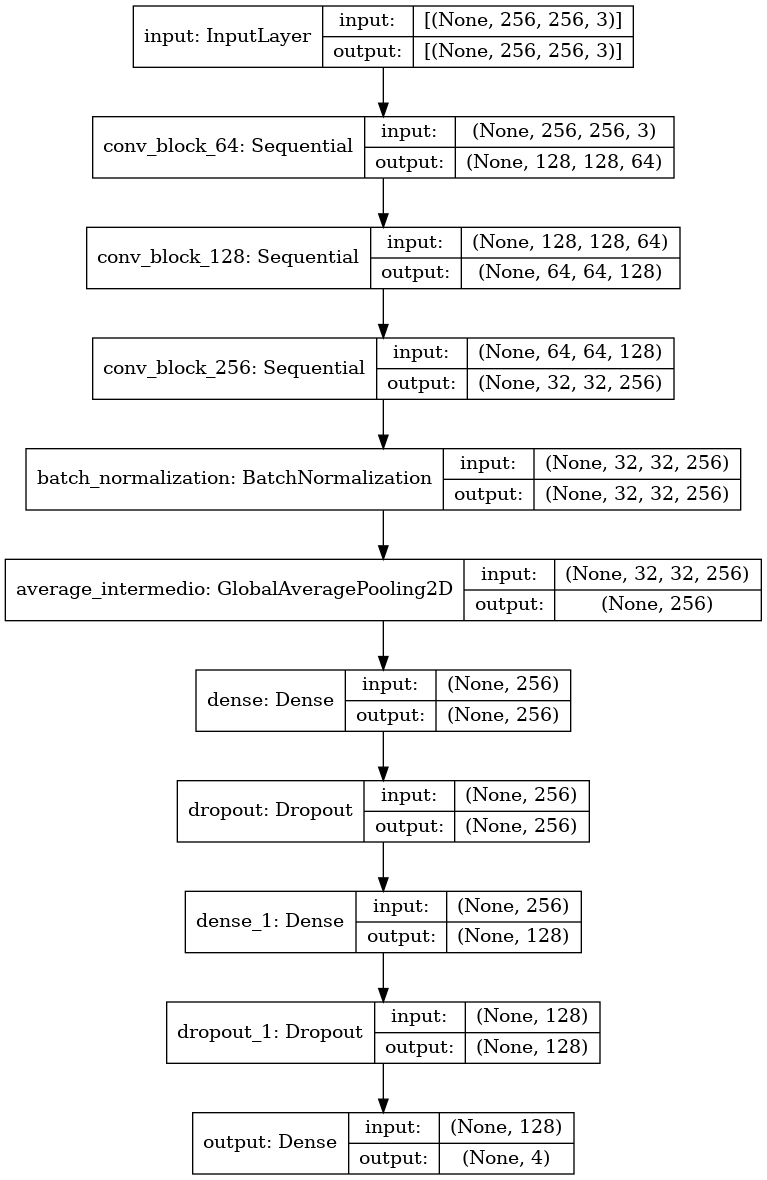

In [11]:
plot_model(test_model,"model_build.png",show_shapes=True)

Una vez obtenidos la arquitectura del modelo
* Generando **Callbacks** para detener el entrenamiento cuando no se tienen buenos resultados


In [12]:
#cuando la funcion de perdida ya no mejora en los datos de validacion.
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                mode="min",
                                                restore_best_weights=True) 
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("base_model_best_check.h5",save_best_only=True)
n_epochs=100

### Entrenamiento el modelo BASE


In [15]:
base_model=build_base_model()
model_history=base_model.fit(
                    train_generator,
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    callbacks=[early_stopping,model_checkpoint],
                    #class_weight=class_weights,#penalizacion de pesos para el balanceo,
                    workers=8
            )

Epoch 1/100
477/477 [==============================] - 263s 523ms/step - loss: 0.6348 - accuracy: 0.4691 - recall: 0.0462 - val_loss: 0.6790 - val_accuracy: 0.4369 - val_recall: 0.0078
Epoch 2/100
477/477 [==============================] - 250s 519ms/step - loss: 0.5358 - accuracy: 0.5462 - recall: 0.1591 - val_loss: 0.4668 - val_accuracy: 0.5847 - val_recall: 0.1226
Epoch 3/100
477/477 [==============================] - 249s 515ms/step - loss: 0.4691 - accuracy: 0.5941 - recall: 0.2679 - val_loss: 0.8173 - val_accuracy: 0.3287 - val_recall: 0.2734
Epoch 4/100
477/477 [==============================] - 249s 514ms/step - loss: 0.4127 - accuracy: 0.6420 - recall: 0.3646 - val_loss: 0.3782 - val_accuracy: 0.6575 - val_recall: 0.3996
Epoch 5/100
477/477 [==============================] - 249s 517ms/step - loss: 0.3695 - accuracy: 0.6576 - recall: 0.4050 - val_loss: 0.3884 - val_accuracy: 0.6106 - val_recall: 0.3516
Epoch 6/100
477/477 [==============================] - 246s 510ms/step - lo

In [33]:
#guardamos el modelo generado
base_model.save("./model_base.h5")

In [17]:

#deseo guardar el History devuelto del entrenamiento
dfhist=pd.DataFrame(model_history.history)
dfhist.to_csv("./model_history.csv",index=False)

Trazamos la curva de la accuracy y funcion de perdida

* Creamos una funcion para reutilizar la funcion que genera el grafico, para los modelos que se probaran mas adelante.

In [18]:

def plot_metrics(history,metrics=[]): #retorna una lista de tuplas
    fig,axes=plt.subplots(1,len(metrics))
    fig.set_size_inches(15,5)
    graph=pd.DataFrame(history)
    for i,ax in enumerate(axes.flat):
        graph[list(metrics[i])].plot(kind="line",style="-",ax=ax)
        ax.set_title(" VS ".join(list(metrics[i])))
        ax.grid(True)
    plt.show()

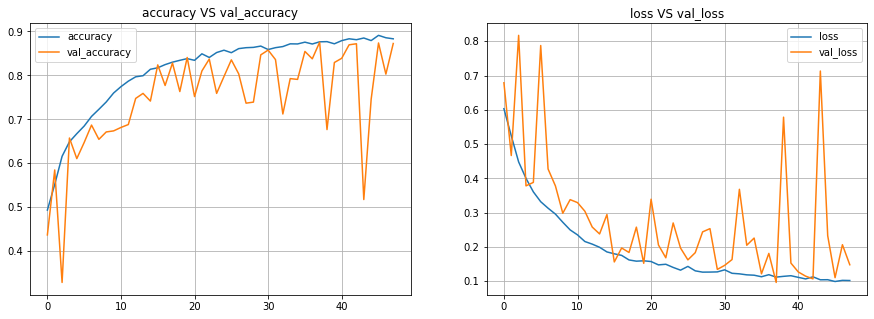

In [19]:
df_history=pd.read_csv("model_history.csv")
history=df_history.to_dict("list")
metrics=[("accuracy","val_accuracy"),("loss","val_loss")]
plot_metrics(history,metrics=metrics)

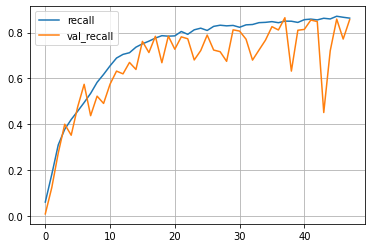

In [20]:
df_history[["recall","val_recall"]].plot(kind="line",style="-")
plt.grid(True)

In [22]:
#obtenemos el numero de epocas donde se detuvo y lo configuramos como un epoch inicial para el siguiente
#entrenamiento
EPOCH_STOP=model_history.epoch[-1]
print("El modelo se entreno en",EPOCH_STOP,"Epochs")

El modelo se entreno en 47 Epochs


* El entrenamiento del modelo se detuvo en 47 epochs lo que nos dice que la funcion de perdida en la data de validacion no mejoro por 10 epochs consecutivos, probablemente, ya no mejore para futuras epocas.

Ahora veamos el rendimiento del modelo base en los datos de entrenamiento y validacion

In [23]:
base_model.evaluate(train_generator)

477/477 [==============================] - 239s 501ms/step - loss: 0.0899 - accuracy: 0.8939 - recall: 0.8789


[0.08986824005842209, 0.8939493298530579, 0.8788554668426514]

In [24]:
base_model.evaluate(validation_generator)

53/53 [==============================] - 29s 541ms/step - loss: 0.1009 - accuracy: 0.8760 - recall: 0.8601


[0.10091470181941986, 0.8760330677032471, 0.860094428062439]

* Mostramos la matriz de confusion en los datos de entrenamiento y validacion

Para el conjunto de entrenamiento

In [25]:
y_true=train_generator.classes
predictions=base_model.predict(train_generator)
y_pred=np.argmax(predictions,axis=1)

In [26]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

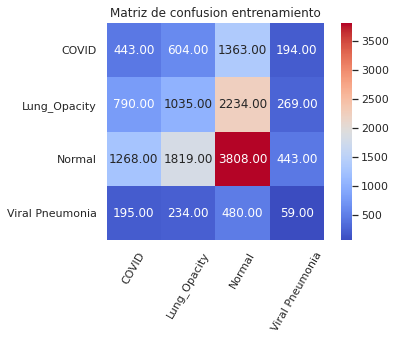

In [27]:
#obtenemos la matriz de confusion de sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
classes=train_generator.class_indices.keys()
mat_train=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_train,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion entrenamiento")
plt.show()

* Reporte de clasificacion para el conjunto de entrenamiento

In [28]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.16      0.17      0.17      2604
   Lung_Opacity       0.28      0.24      0.26      4328
         Normal       0.48      0.52      0.50      7338
Viral Pneumonia       0.06      0.06      0.06       968

       accuracy                           0.35     15238
      macro avg       0.25      0.25      0.25     15238
   weighted avg       0.34      0.35      0.35     15238



* Para el conjunto de validacion

In [29]:
y_true=validation_generator.classes
predictions=base_model.predict(validation_generator)
y_pred=np.argmax(predictions,axis=1)

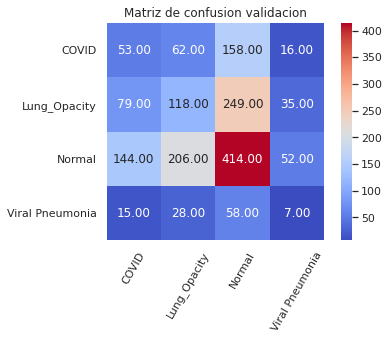

In [30]:
classes=validation_generator.class_indices.keys()
mat_val=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_val,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion validacion")
plt.show()

* Reporte de clasificacion para los datos de validacion

In [31]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.18      0.18      0.18       289
   Lung_Opacity       0.29      0.25      0.26       481
         Normal       0.47      0.51      0.49       816
Viral Pneumonia       0.06      0.06      0.06       108

       accuracy                           0.35      1694
      macro avg       0.25      0.25      0.25      1694
   weighted avg       0.34      0.35      0.35      1694



In [32]:
#guardamos la documentacion del entrenamiento
train_generator.class_indices.keys()

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'])

### RESULTADOS FINALES: MODELO CON PERDIDA FOCAL PARA EL BALANCEO DE CLASES
* El modelo base ha obtenido un puntaje de accuracy **ACC=89%** y recall **RECALL=87.89%** en el **conjunto de entrenamiento**.

* El modelo ha obtendio un puntaje de accuracy **ACC=87.%** y recall **RECALL=86.%** en el **conjunto de validacion**.

**IMPORTANTE**: El modelo ha alcanzado un poco equilibrio entre los datos de entrenamiento y validacion, lo que siginifica que es un modelo final con aproximadamente 82% de precision. Este modelo pasará a la **Fase de evaluación del modelo**.